# Water Survey of Canada

Historical data for lake levels and stream flows in the Rainy Lake watershed are publically available from several sources including the [HYDAT database](https://www.ec.gc.ca/rhc-wsc/default.asp?lang=En&n=9018B5EC-1) from the [Water Survey of Canada (WSC)](http://wateroffice.ec.gc.ca/). 

The [HYDAT database](https://www.ec.gc.ca/rhc-wsc/default.asp?lang=En&n=9018B5EC-1) database consists of Microsoft Access .mdb file providing over a century of data on daily water flows and levels throughout Canada. Individual tables (STATIONS, DLY_FLOWS, and DLY_LEVELS) were exported from the database as .csv files using [MDB Explorer](http://www.mdbexplorer.com/). Because of the size of the database, the following cells extract information relevant to the Rainy River drainage basin and stores the results in this repository's data directory.

These involve lengthy processing of large data sets. The notebooks needs to be run whenever a new version of the HYDAT database becomes available, normally on a quarterly basis.

### Table of Contents

* [Initialization](#Initialization)

<a id="Initialization"></a>
## Initialization

In [1]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import requests

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Directory where data files have been stored
HYDAT_dir = "/Users/jeff/Box Sync/RLPOA Technical Committee/Historical Data/HYDAT/"

## Monitoring Stations

We identify monitoring stations within the HYDAT database that are within the area of interest. For reference, this is a map of the [Rainy River drainage](http://www.ijc.org/files/tinymce/uploaded/rl_basinmap.pdf) basin available from the International Joint Commission..

<p align='center'><img src='../images/75242923.png' width = 480>
</p>

In [2]:
# bounding region
lngW = -94.0
lngE = -90.5
latS = 47.5
latN = 49.0

# load complete STATIONS database
STATIONS = pd.read_csv(HYDAT_dir + 'STATIONS.csv', index_col = 0);
print "    Stations in the HYDAT database = ", len(STATIONS.index)

# locate monitoring stations within bounding region
stationList = STATIONS[(STATIONS['LATITUDE'] >= latS) & \
         (STATIONS['LATITUDE'] <= latN) & \
         (STATIONS['LONGITUDE'] <= lngE) & \
         (STATIONS['LONGITUDE'] >= lngW)].index

print "Stations within region of interest = ", len(stationList)

display(STATIONS.ix[stationList,['STATION_NAME','LATITUDE','LONGITUDE']])

    Stations in the HYDAT database =  7775
Stations within region of interest =  34


,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PA001,KETTLE RIVER ABOVE KETTLE FALLS,48.49444,-92.64444
05PA003,NAMAKAN LAKE ABOVE KETTLE FALLS DAM,48.50000,-92.63886
05PA005,NORTHERN LIGHT LAKE AT OUTLET,48.24028,-90.76889
05PA006,NAMAKAN RIVER AT OUTLET OF LAC LA CROIX,48.38256,-92.17631
05PA007,CROOKED LAKE NEAR CURTAIN FALLS,48.23750,-91.90611
05PA010,FRENCH LAKE NEAR ATIKOKAN,48.67222,-91.13500
05PA011,LAC LA CROIX AT CAMPBELL'S CAMP,48.35508,-92.21744
05PA012,BASSWOOD RIVER NEAR WINTON,48.08256,-91.65117
05PA013,NAMAKAN LAKE AT SQUIRREL ISLAND,48.49686,-92.65856


## Level Monitoring Stations

In [3]:
DLY_LEVELS = pd.read_csv(HYDAT_dir + 'DLY_LEVELS.csv')

In [4]:
levelStations = set(DLY_LEVELS['STATION_NUMBER']).intersection(stationList)
display(STATIONS.ix[levelStations,['STATION_NAME','LATITUDE','LONGITUDE']])

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PA003,NAMAKAN LAKE ABOVE KETTLE FALLS DAM,48.50000,-92.63886
05PA010,FRENCH LAKE NEAR ATIKOKAN,48.67222,-91.13500
05PA012,BASSWOOD RIVER NEAR WINTON,48.08256,-91.65117
05PA013,NAMAKAN LAKE AT SQUIRREL ISLAND,48.49686,-92.65856
05PA007,CROOKED LAKE NEAR CURTAIN FALLS,48.23750,-91.90611
05PA006,NAMAKAN RIVER AT OUTLET OF LAC LA CROIX,48.38256,-92.17631
05PA005,NORTHERN LIGHT LAKE AT OUTLET,48.24028,-90.76889
05PA011,LAC LA CROIX AT CAMPBELL'S CAMP,48.35508,-92.21744
05PB023,RAINY LAKE AT NORTHWEST BAY,48.84167,-93.62000


<IPython.core.display.Javascript object>


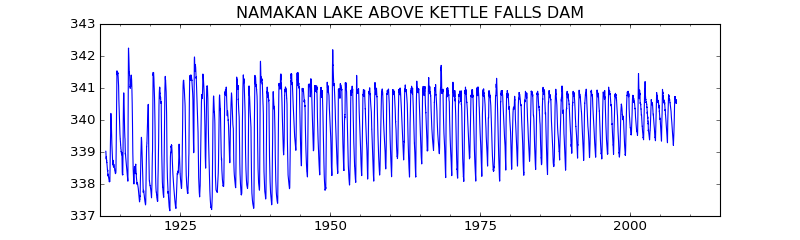

<IPython.core.display.Javascript object>


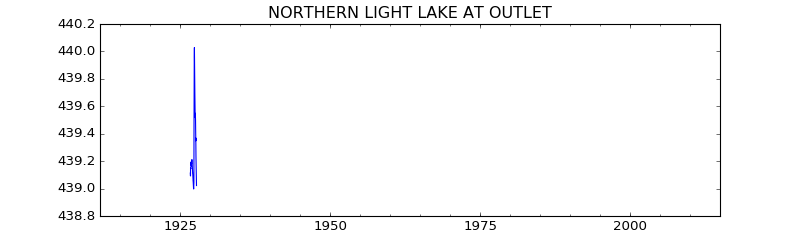

<IPython.core.display.Javascript object>


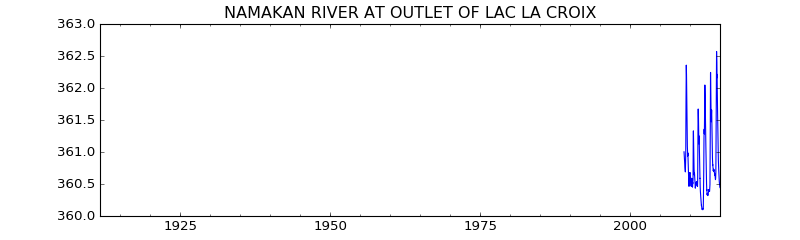

<IPython.core.display.Javascript object>


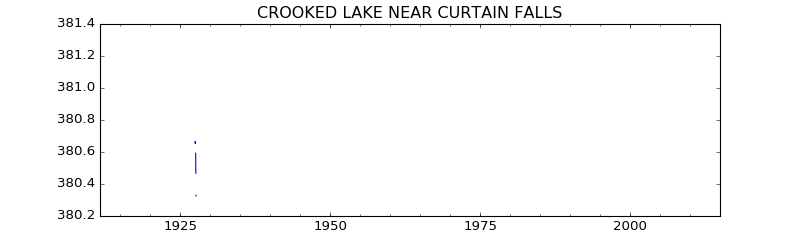

<IPython.core.display.Javascript object>


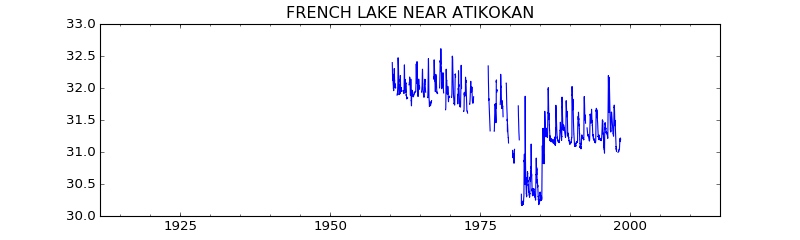

<IPython.core.display.Javascript object>


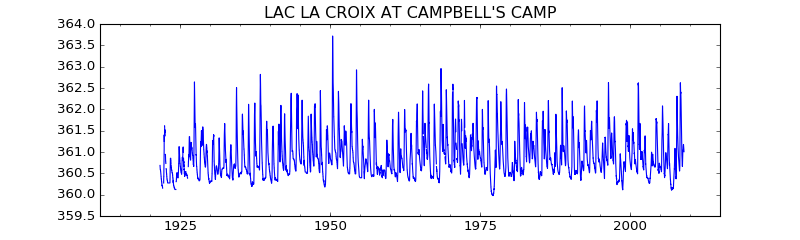

<IPython.core.display.Javascript object>


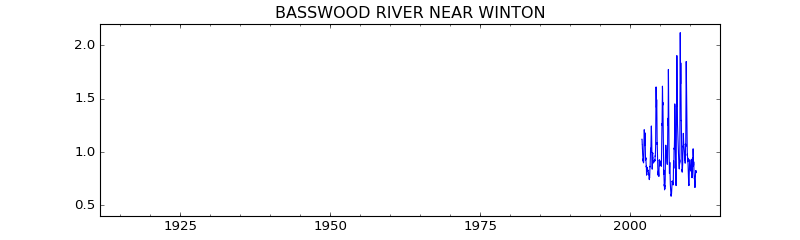

<IPython.core.display.Javascript object>


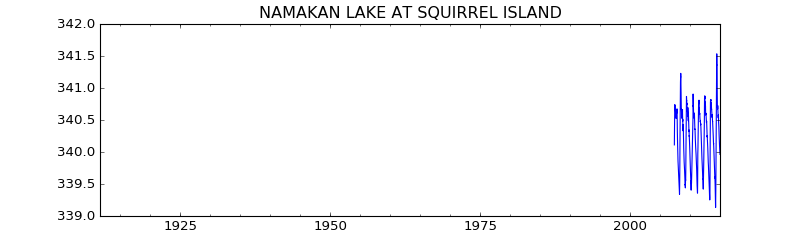

<IPython.core.display.Javascript object>


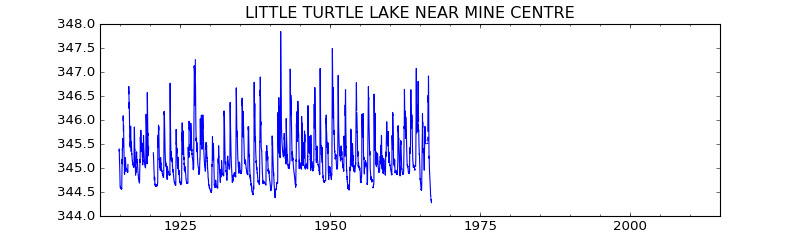

<IPython.core.display.Javascript object>


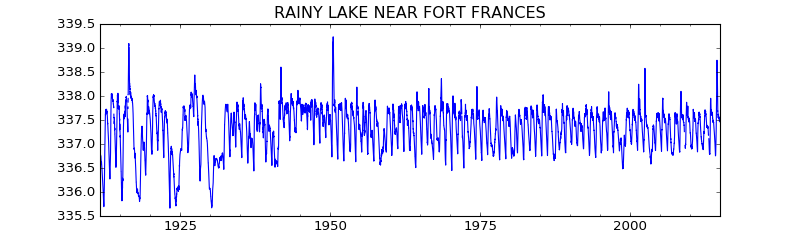

<IPython.core.display.Javascript object>


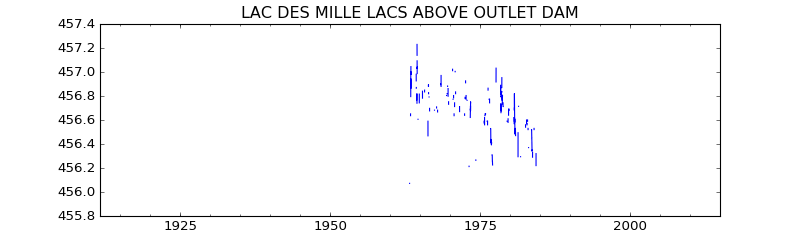

<IPython.core.display.Javascript object>


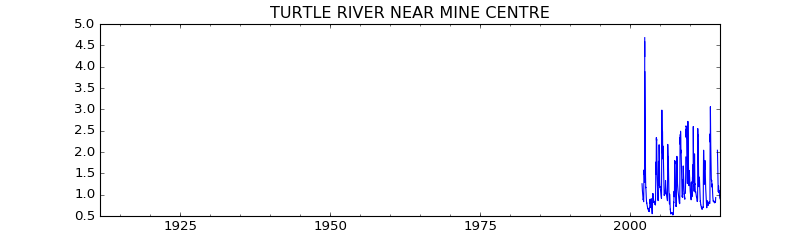

<IPython.core.display.Javascript object>


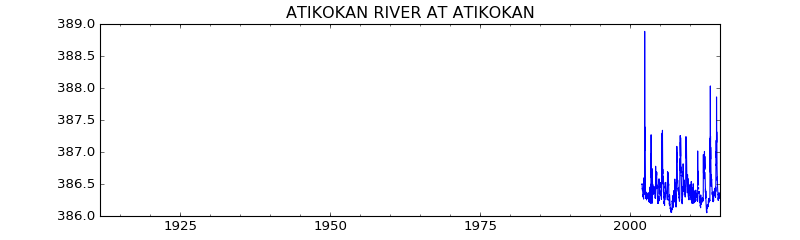

<IPython.core.display.Javascript object>


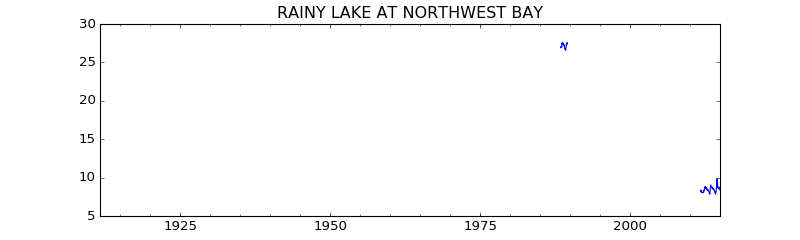

<IPython.core.display.Javascript object>


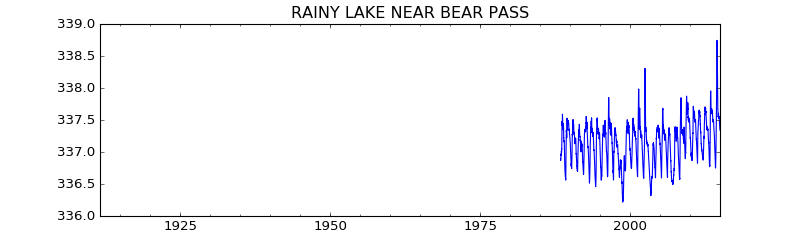

<IPython.core.display.Javascript object>


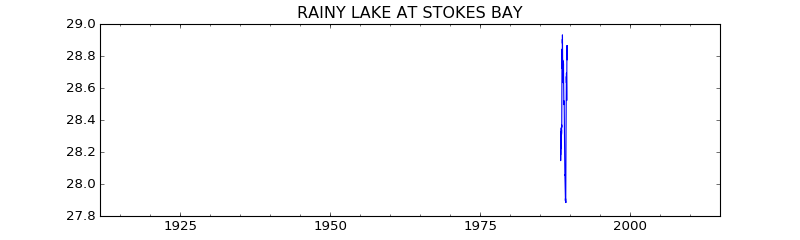

<IPython.core.display.Javascript object>


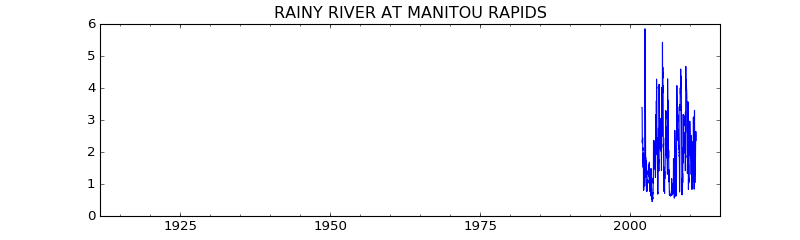

<IPython.core.display.Javascript object>


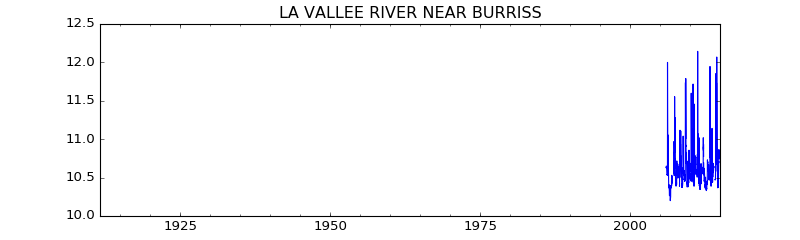

<IPython.core.display.Javascript object>


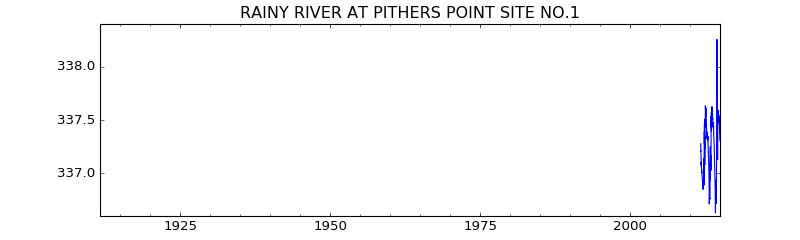

<IPython.core.display.Javascript object>


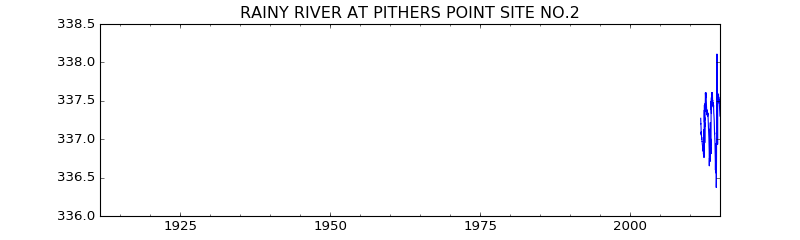

In [5]:
def getLevelsWSC(s):
    ts = {}   
    data = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'] == s]
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'LEVEL'+str(n)]  
    ts = pd.Series(ts)
    #drop initial and terminal null entries
    j = 0
    while j<len(ts.index) and pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while k>=j and pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k+1]

WSC_LEVELS = pd.DataFrame({s:getLevelsWSC(s) for s in levelStations})

for s in WSC_LEVELS.columns:
    plt.figure(figsize=(10,3))
    WSC_LEVELS[s].plot()
    plt.title(STATIONS.ix[s,'STATION_NAME'])
    
WSC_LEVELS.to_pickle('../data/WSC_LEVELS')

## Flow Monitoring Stations

In [6]:
DLY_FLOWS = pd.read_csv(HYDAT_dir + 'DLY_FLOWS.csv')

In [7]:
flowStations = set(DLY_FLOWS['STATION_NUMBER']).intersection(stationList)
display(STATIONS.ix[flowStations,['STATION_NAME','LATITUDE','LONGITUDE']])

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PA012,BASSWOOD RIVER NEAR WINTON,48.08256,-91.65117
05PC016,LA VALLEE RIVER NEAR DEVLIN,48.59028,-93.67278
05PA006,NAMAKAN RIVER AT OUTLET OF LAC LA CROIX,48.38256,-92.17631
05PB014,TURTLE RIVER NEAR MINE CENTRE,48.85022,-92.72383
05PB020,EASTERN TRIBUTARY TO DASHWA LAKE NEAR ATIKOKAN,48.94056,-91.69833
05PB021,EYE RIVER NEAR HARDTACK LAKE NORTH OF ATIKOKAN,48.92500,-91.66222
05PB022,EYE RIVER NEAR COULSON LAKE NORTH OF ATIKOKAN,48.89444,-91.66750
05PA001,KETTLE RIVER ABOVE KETTLE FALLS,48.49444,-92.64444
05PC022,LA VALLEE RIVER NEAR BURRISS,48.67844,-93.66522


The next cell defines a utility function to create a Pandas Series containing the history of flow data for a given WSC sensor. The returned object indexed with a daily timestamp.

/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


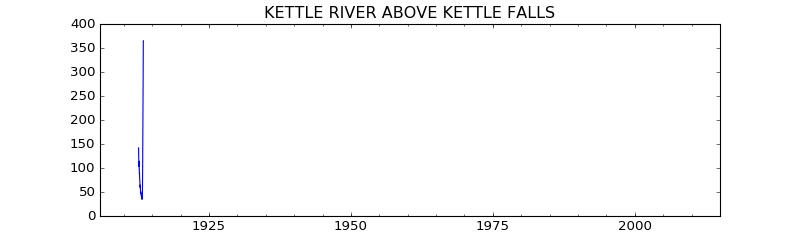

<IPython.core.display.Javascript object>


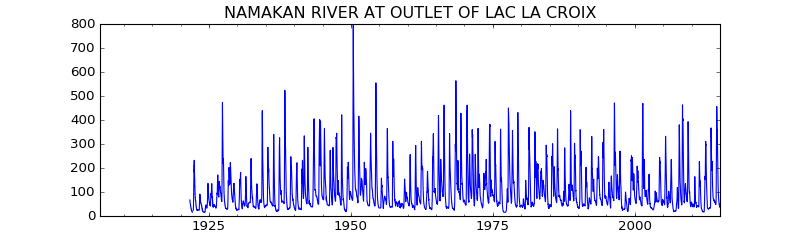

<IPython.core.display.Javascript object>


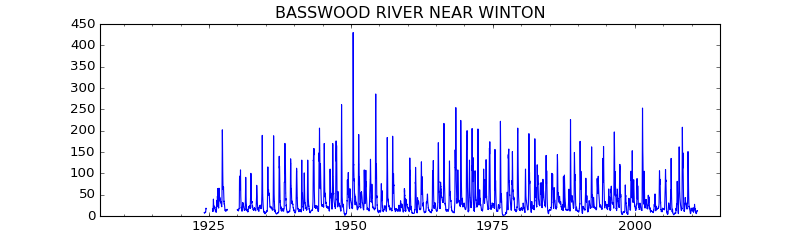

<IPython.core.display.Javascript object>


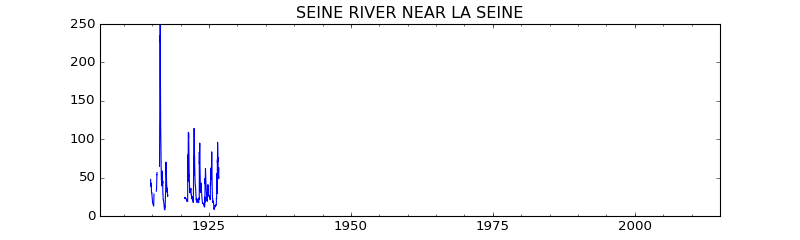

<IPython.core.display.Javascript object>


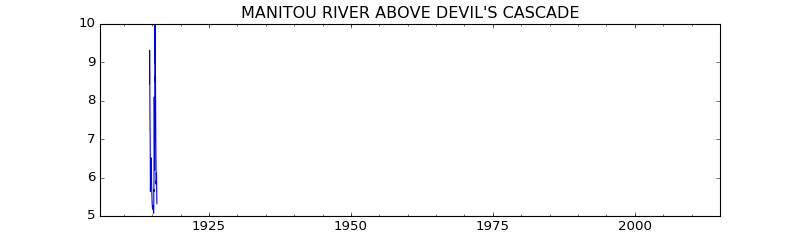

<IPython.core.display.Javascript object>


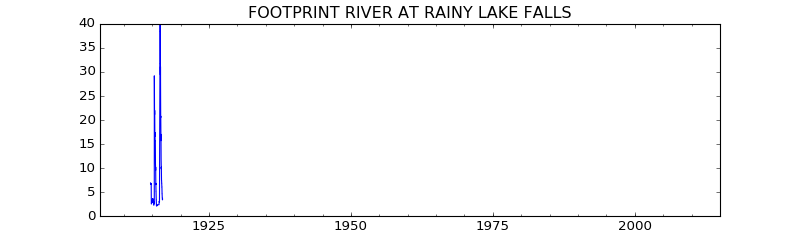

<IPython.core.display.Javascript object>


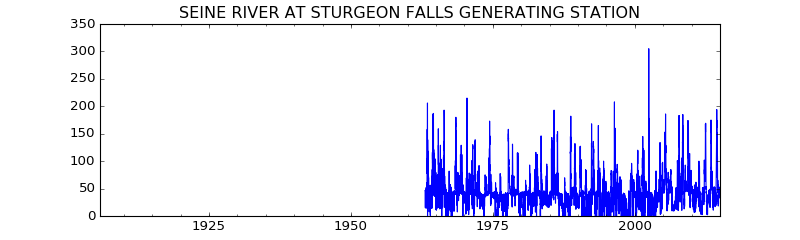

<IPython.core.display.Javascript object>


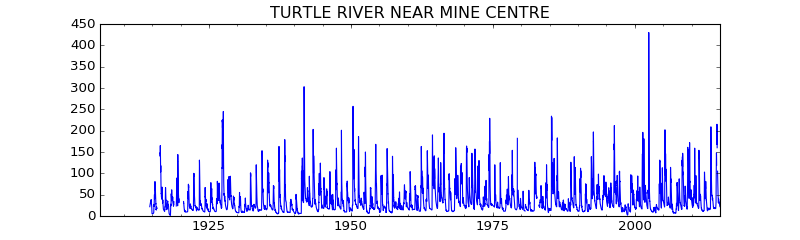

<IPython.core.display.Javascript object>


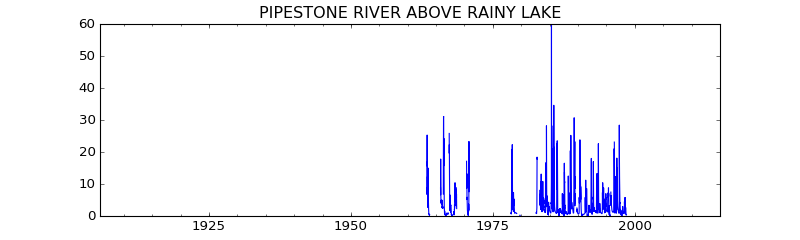

<IPython.core.display.Javascript object>


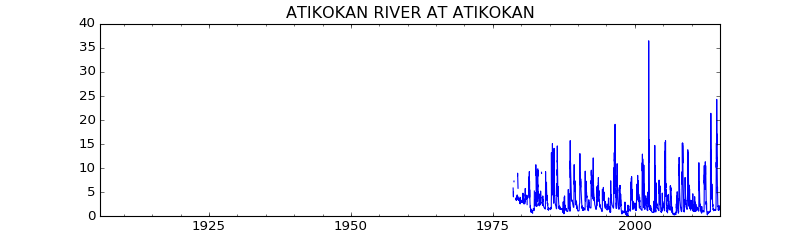

<IPython.core.display.Javascript object>


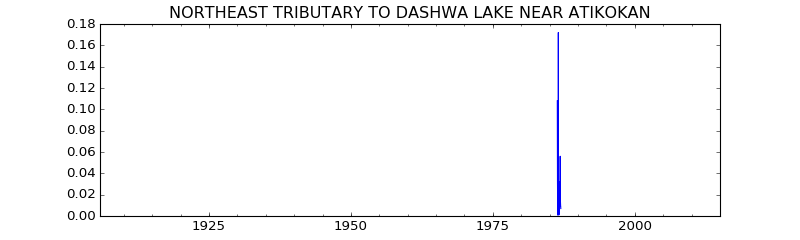

<IPython.core.display.Javascript object>


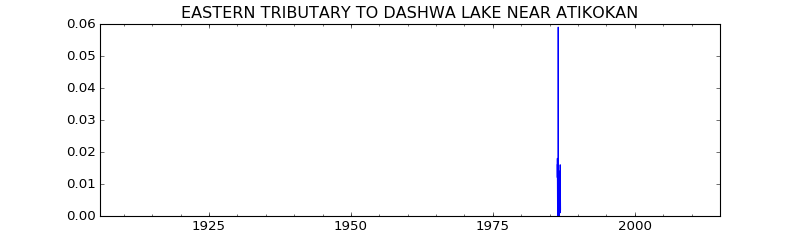

<IPython.core.display.Javascript object>


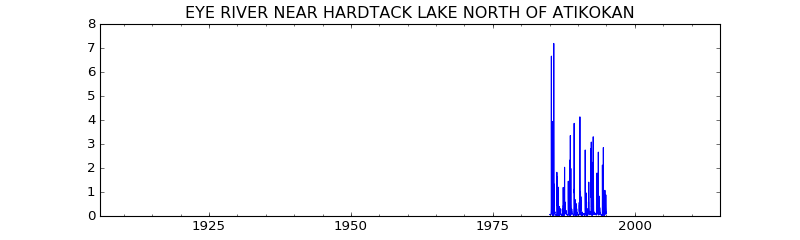

<IPython.core.display.Javascript object>


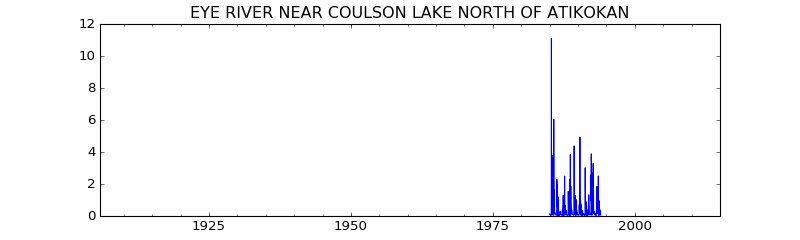

<IPython.core.display.Javascript object>


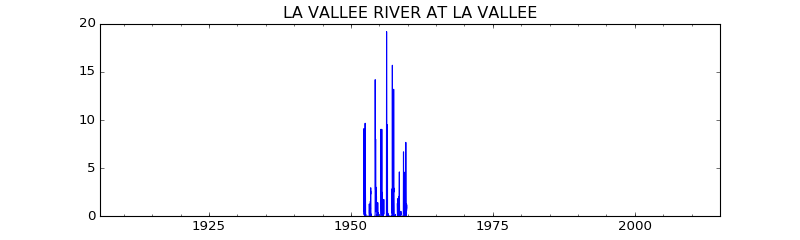

<IPython.core.display.Javascript object>


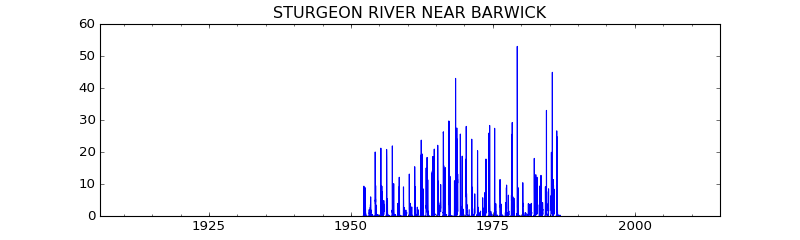

<IPython.core.display.Javascript object>


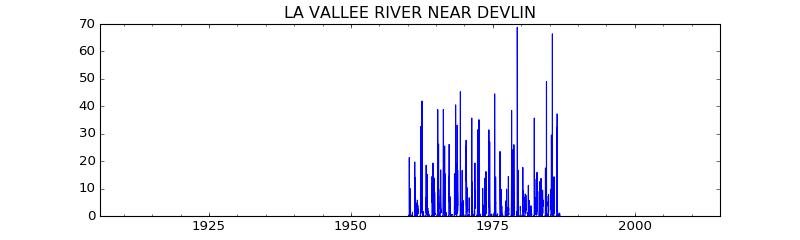

<IPython.core.display.Javascript object>


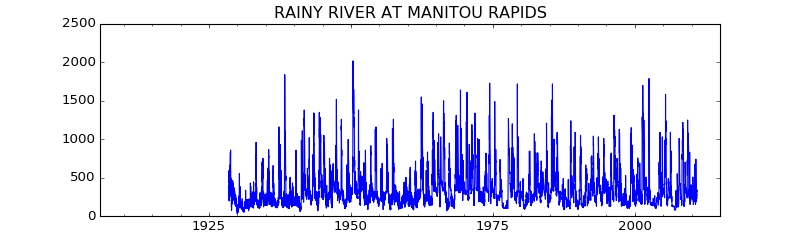

<IPython.core.display.Javascript object>


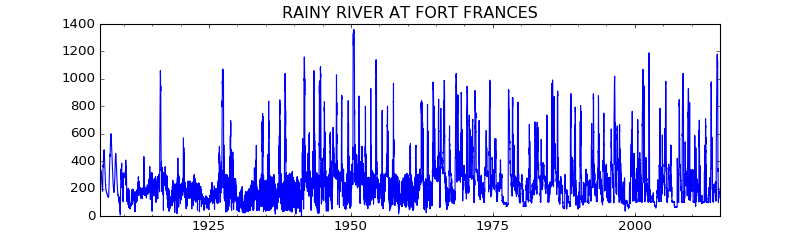

<IPython.core.display.Javascript object>


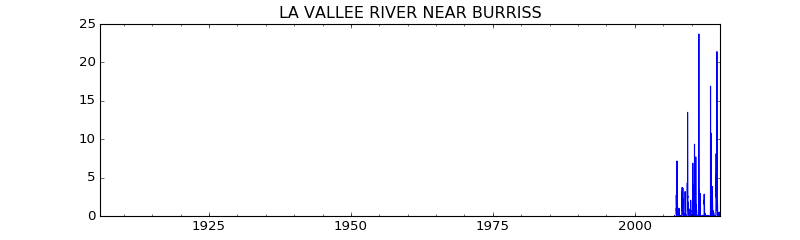

In [10]:
def getFlowsWSC(s):
    ts = {}
    data = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'] == s]
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'FLOW'+str(n)]  
    ts = pd.Series(ts)
    ts.name = s +': ' + STATIONS.ix[s,'STATION_NAME'] + \
        ' from ' + '{0}'.format(ts.index[0].year) + \
        ' to ' + '{0}'.format(ts.index[-1].year)
    #drop initial and terminal null entries
    j = 0
    while j<len(ts.index) and pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while k>=j and pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k+1]

WSC_FLOWS = pd.DataFrame({s: getFlowsWSC(s) for s in flowStations})

for s in WSC_FLOWS.columns:
    plt.figure(figsize=(10,3))
    WSC_FLOWS[s].plot()
    plt.title(STATIONS.ix[s,'STATION_NAME'])
    
WSC_FLOWS.to_pickle('../data/WSC_FLOWS')

## Mapping WSC Stations

The following function maps a list of stations identified by their station numbers. In extracts latitude and longitude from the STATIONS table, then calls the google maps web api to create a map image.

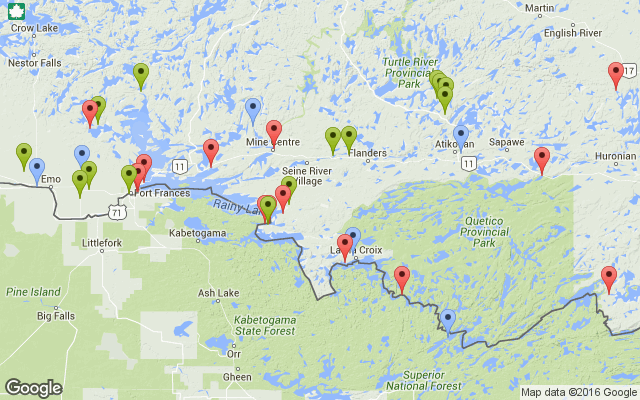

In [15]:
# Create a map of level and flow measurement stations
def mapWSC(lvlList,floList=[]):
    # return a .png map image
    #S = STATIONS.ix[rList,['STATION_NAME','LATITUDE','LONGITUDE']]
    rSet = set(lvlList).difference(set(floList))
    gSet = set(floList).difference(set(lvlList))
    bSet = set(lvlList).intersection(set(floList))

    rMarkers = '&markers=color:red%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(STATIONS.ix[s,'LATITUDE'], \
                                   STATIONS.ix[s,'LONGITUDE']) for s in rSet]) 
    gMarkers = '&markers=color:green%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(STATIONS.ix[s,'LATITUDE'], \
                                   STATIONS.ix[s,'LONGITUDE']) for s in gSet])
    bMarkers = '&markers=color:blue%7Csize:mid%7C' + \
        "|".join(["{0},{1}".format(STATIONS.ix[s,'LATITUDE'], \
                                   STATIONS.ix[s,'LONGITUDE']) for s in bSet])
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x400" + \
        "&maptype=terrain" + \
        rMarkers + gMarkers + bMarkers
    return Image(requests.get(google_maps_url).content)

img = mapWSC(levelStations,flowStations)
display(img)

In [10]:
WSC_STATIONS = pd.DataFrame(index=stationList)
WSC_STATIONS['Level'] = pd.Series(False,index = stationList)
WSC_STATIONS.ix[levelStations] = True 

WSC_STATIONS['Flow'] = pd.Series(False,index = stationList)
WSC_STATIONS.ix[flowStations] = True 
WSC_STATIONS.ix[stationList,'STATION_NAME'] = STATIONS.ix[stationList,'STATION_NAME']
WSC_STATIONS.ix[stationList,'LATITUDE'] = STATIONS.ix[stationList,'LATITUDE']
WSC_STATIONS.ix[stationList,'LONGITUDE'] = STATIONS.ix[stationList,'LONGITUDE']

WSC_STATIONS

,Level,Flow,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,,,
05PA001,True,True,KETTLE RIVER ABOVE KETTLE FALLS,48.49444,-92.64444
05PA003,True,False,NAMAKAN LAKE ABOVE KETTLE FALLS DAM,48.50000,-92.63886
05PA005,True,False,NORTHERN LIGHT LAKE AT OUTLET,48.24028,-90.76889
05PA006,True,True,NAMAKAN RIVER AT OUTLET OF LAC LA CROIX,48.38256,-92.17631
05PA007,True,False,CROOKED LAKE NEAR CURTAIN FALLS,48.23750,-91.90611
05PA010,True,False,FRENCH LAKE NEAR ATIKOKAN,48.67222,-91.13500
05PA011,True,False,LAC LA CROIX AT CAMPBELL'S CAMP,48.35508,-92.21744
05PA012,True,True,BASSWOOD RIVER NEAR WINTON,48.08256,-91.65117
05PA013,True,False,NAMAKAN LAKE AT SQUIRREL ISLAND,48.49686,-92.65856


## Create `hydat.h5` Data Cache

Reading the entire HYDAT database is a lengthy operation, and because of file size constraints, the entire data set can not be stored in a github repository or hosted on a docker server. For those reaaons, the an HDF5 data cache is created in the local repository to include selected data relevant to the Rainy/Namakan system.

In [11]:
from os.path import isfile
from os import remove

if isfile('../data/hydat.h5'):
    print 'Delete old ../data/hydat.h5'
    remove('../data/hydat.h5')
    
print 'Creating new ../data/hydat.h5'
hydat = pd.HDFStore('../data/hydat.h5')
    
# store data in hydat.h5
hydat['STATIONS'] = STATIONS.ix[stationList].groupby(level=0).last()
hydat['DLY_FLOWS'] = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'].isin(flowStations)]
hydat['DLY_LEVELS'] = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'].isin(levelStations)]

print hydat
hydat.close()
print hydat

/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['STATION_NUMBER', 'FLOW_SYMBOL1', 'FLOW_SYMBOL2', 'FLOW_SYMBOL3', 'FLOW_SYMBOL4', 'FLOW_SYMBOL5', 'FLOW_SYMBOL6', 'FLOW_SYMBOL7', 'FLOW_SYMBOL8', 'FLOW_SYMBOL9', 'FLOW_SYMBOL10', 'FLOW_SYMBOL11', 'FLOW_SYMBOL12', 'FLOW_SYMBOL13', 'FLOW_SYMBOL14', 'FLOW_SYMBOL15', 'FLOW_SYMBOL16', 'FLOW_SYMBOL17', 'FLOW_SYMBOL18', 'FLOW_SYMBOL19', 'FLOW_SYMBOL20', 'FLOW_SYMBOL21', 'FLOW_SYMBOL22', 'FLOW_SYMBOL23', 'FLOW_SYMBOL24', 'FLOW_SYMBOL25', 'FLOW_SYMBOL26', 'FLOW_SYMBOL27', 'FLOW_SYMBOL28', 'FLOW_SYMBOL29', 'FLOW_SYMBOL30', 'FLOW_SYMBOL31']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jeff/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTabl

Delete old ../data/hydat.h5
Creating new ../data/hydat.h5
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
/DLY_FLOWS             frame        (shape->[7965,73])
/DLY_LEVELS            frame        (shape->[5913,74])
/STATIONS              frame        (shape->[34,14])  
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
File is CLOSED


## Reading `hydat.h5` Data Cache

In [13]:
from os.path import isfile
hydat = pd.HDFStore('../data/hydat.h5')

# reload from cache (to verify data round trip)
STATIONS = hydat['STATIONS']
DLY_LEVELS = hydat['DLY_LEVELS']
DLY_FLOWS = hydat['DLY_FLOWS']

print hydat
hydat.close()
print hydat

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
/DLY_FLOWS             frame        (shape->[7965,73])
/DLY_LEVELS            frame        (shape->[5913,74])
/STATIONS              frame        (shape->[34,14])  
<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
File is CLOSED


## Use Case Examples

#### Example: Station Data

The HYDAT database is a collection of data associated with monitoring stations located throughout Canada. The STATIONS table contains a list of stations and attributes, including the latitude and longitude of their position. As an example, here we list attributes for 05PB007, a station monitoring the level of Rainy Lake near Fort Frances, Ontario.

In [35]:
STATIONS.ix['05PB007']

STATION_NAME            RAINY LAKE NEAR FORT FRANCES
PROV_TERR_STATE_LOC                               ON
REGIONAL_OFFICE_ID                                 5
HYD_STATUS                                         A
SED_STATUS                                       NaN
LATITUDE                                     48.6491
LONGITUDE                                   -93.3207
DRAINAGE_AREA_GROSS                              NaN
DRAINAGE_AREA_EFFECT                             NaN
RHBN                                               0
REAL_TIME                                          1
CONTRIBUTOR_ID                                   647
OPERATOR_ID                                      647
DATUM_ID                                         100
Name: 05PB007, dtype: object

In [36]:
WSC_STATIONS.ix['05PB007']

Level                                   True
Flow                                   False
STATION_NAME    RAINY LAKE NEAR FORT FRANCES
LATITUDE                             48.6491
LONGITUDE                           -93.3207
Name: 05PB007, dtype: object

#### Example: Plotting level and flow information

<IPython.core.display.Javascript object>


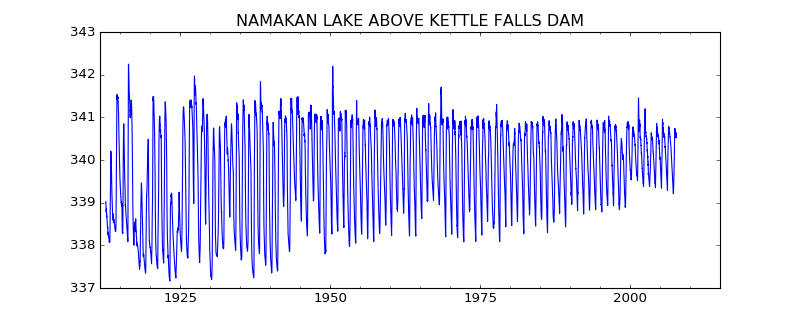

<IPython.core.display.Javascript object>


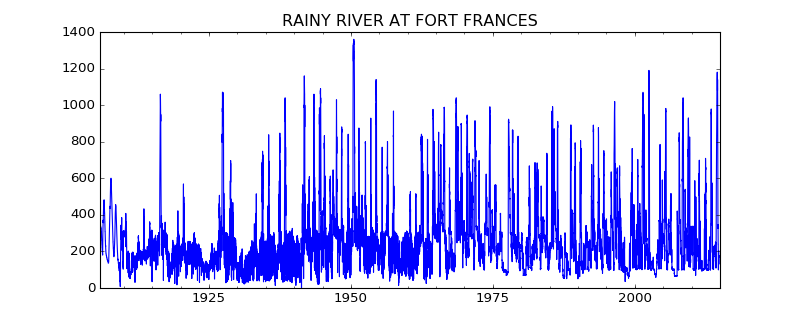

In [34]:
%matplotlib notebook

s = '05PA003'
plt.figure(figsize=(10,4))
WSC_LEVELS[s].plot()
plt.title(WSC_STATIONS.ix[s,'STATION_NAME'])

s = '05PC019'
plt.figure(figsize=(10,4))
WSC_FLOWS[s].plot()
plt.title(WSC_STATIONS.ix[s,'STATION_NAME'])

#### Example: Comparing Levels on Rainy and Namakan Lakes

Use of this function is demonstrated by reading and plotting the history of lake levels for Rainy and Namakan Lakes.

<IPython.core.display.Javascript object>


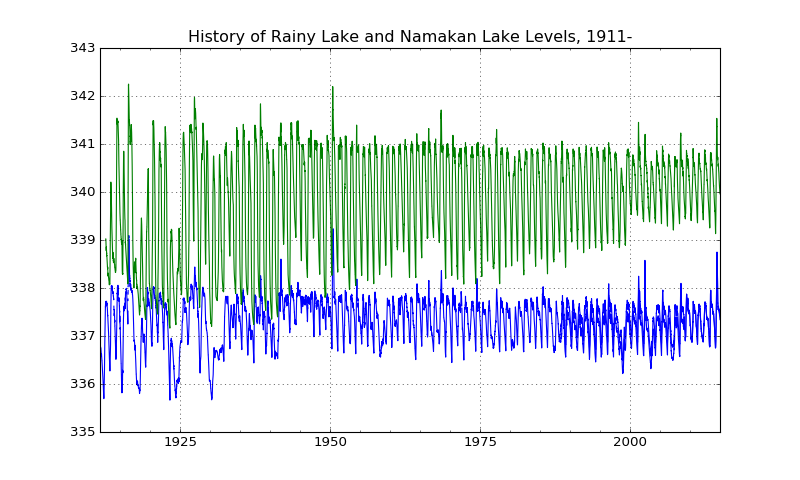

In [32]:
plt.figure(figsize=(10,6))
plt.hold(True)
WSC_LEVELS['05PB007'].plot(color='blue')   # RL at Fort Frances
WSC_LEVELS['05PB024'].plot(color='blue')   # RL at Bear's Pass
WSC_LEVELS['05PA003'].plot(color='green')  # NL at Kettle Falls
WSC_LEVELS['05PA013'].plot(color='green')  # NL at Squirrel Island

plt.hold(False)
#plt.legend([RL.name,NL.name]);
plt.title('History of Rainy Lake and Namakan Lake Levels, 1911-')
plt.grid()

#### Example: Distribution of Flows on Rainy River

The use of this function is demonstrated by creating a historgram of flows on Rainy River in the period 

In [15]:
RR = WSC_FLOWS['05PC019']
RM = WSC_FLOWS['05PC018']

<IPython.core.display.Javascript object>


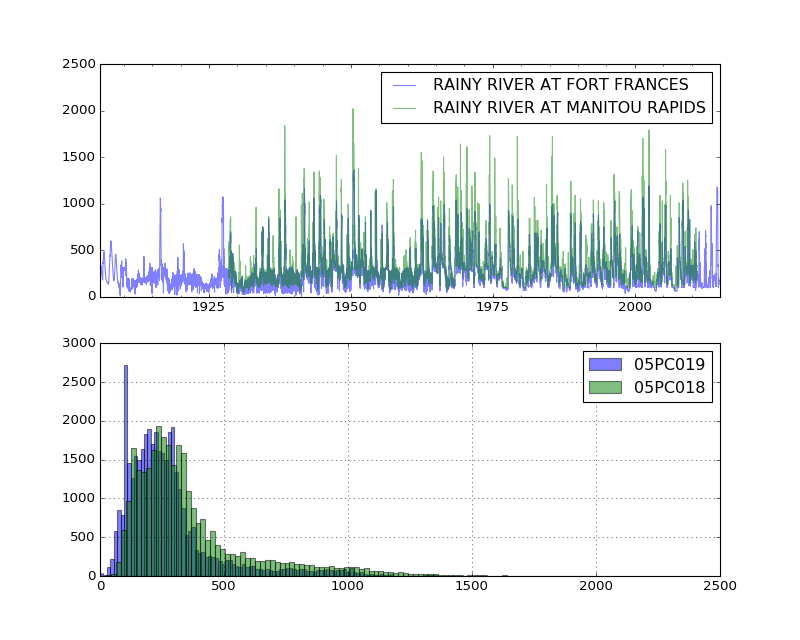

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hold(True)
RR.plot(alpha=0.5)
RM.plot(alpha=0.5)
plt.legend([WSC_STATIONS.ix[RR.name,'STATION_NAME'],WSC_STATIONS.ix[RM.name,'STATION_NAME']])
plt.hold(False)
plt.subplot(2,1,2)
plt.hold(True)
RR.hist(bins=100,alpha=0.5)
RM.hist(bins=100,alpha=0.5)
plt.hold(False)
plt.legend([RR.name,RM.name])
